# Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model

* Ref: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
* Data: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/TSLA.csv',
                 header=0,
                 index_col=0,
                 parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-10,262.220001,263.000000,257.820007,259.149994,259.149994,2610900
2015-07-13,262.250000,262.549988,256.049988,262.160004,262.160004,2960300
2015-07-14,262.100006,265.989990,260.510010,265.649994,265.649994,1907600
2015-07-15,266.739990,267.489990,262.079987,263.140015,263.140015,2021600
2015-07-16,264.220001,267.200012,263.160004,266.679993,266.679993,1616000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-07-10 to 2020-07-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


* 注意 index 必須是 DatetimeIndex
* 畫圖看分佈，只看 `Close` 欄位的股價

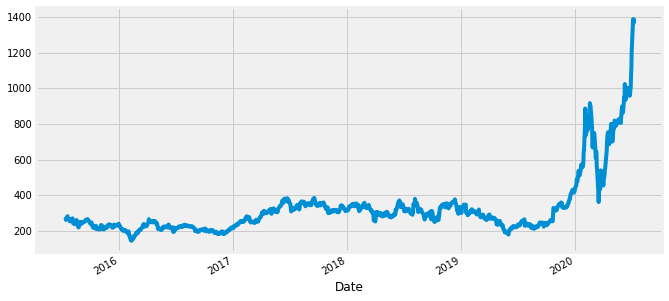

In [ ]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(10, 5))
df['Close'].plot(ax=ax)
plt.show()

## 2. Preprocessing data
* Data preprocessing 包含了
  * 把 data 分成 training 和 test
  * normalize data
  * 把 data 變成 numpy ndarray
  * 把 data 的 numpy ndarray 的維度變成 LSTM 接受的 (row 數目, time steps, feature 的數目)
    * 就是要用 time steps 個元素來預測幾個數
* 上面這些步驟對 training 和 test data 都要做 

In [ ]:
import math
import numpy as np

# import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
# from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
num = int(len(df) * 0.7)
print(num)

training_set = df.iloc[:num]['Close'].values
testing_set = df.iloc[num:]['Close'].values

print(len(training_set), type(training_set), training_set.shape) # training_set 是一個 1-d array
print(training_set[:10])

print(len(testing_set), type(testing_set), testing_set.shape) # testing_set 是一個 1-d array
print(testing_set[:10])

881
881 <class 'numpy.ndarray'> (881,)
[259.149994 262.160004 265.649994 263.140015 266.679993 274.660004
 282.26001  266.769989 267.869995 267.200012]
378 <class 'numpy.ndarray'> (378,)
[338.529999 344.970001 347.26001  334.399994 344.429993 346.049988
 347.309998 302.26001  298.920013 287.589996]


* 要把 data normalize
  * 用 `MinMaxScaler`
* 因為目前 training_set 和 testing_set 都是 1-d array, 必須要改成 2-d array 才能餵給 `MinMaxScaler`

In [ ]:
training_set = training_set.reshape(-1, 1) # 把 training_set 改成 2-d array
print(training_set.shape)
print(training_set[:10]) # 每個元素自成一個 row，然後只有一個 column

(881, 1)
[[259.149994]
 [262.160004]
 [265.649994]
 [263.140015]
 [266.679993]
 [274.660004]
 [282.26001 ]
 [266.769989]
 [267.869995]
 [267.200012]]


In [ ]:
# Feature Scaling
scaler = MinMaxScaler(feature_range = (0, 1)) # normalize 到 0 ~ 1 之間
training_set_scaled = scaler.fit_transform(training_set)
print(training_set_scaled[:10])

[[0.47851488]
 [0.49098747]
 [0.50544895]
 [0.49504834]
 [0.50971696]
 [0.54278376]
 [0.57427593]
 [0.51008988]
 [0.51464798]
 [0.51187176]]


In [ ]:
testing_set_scaled = scaler.transform(testing_set.reshape(-1, 1))
print(testing_set_scaled[:10])

[[0.80744209]
 [0.83412755]
 [0.84361667]
 [0.79032857]
 [0.83188992]
 [0.83860269]
 [0.8438238 ]
 [0.65715   ]
 [0.64331005]
 [0.59636181]]


* 接下來要把 training_set 的格式改成 LSTM 吃的格式，這邊使用 60 time steps
  * time steps = N 就是表示每一 row 有 N 個元素
  * LSTM 吃的格式是 [ [row_1 N 個元素], [row_2 N 個元素], ...] 

In [ ]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []

time_steps = 60
length = len(training_set_scaled)

for i in range(time_steps, length):
  X_train.append(training_set_scaled[i - time_steps : i, 0]) # training_set_scaled 是 (881, 1) 的 2-d array 要取出每個 row 的元素時要用 [row, 0]
  y_train.append(training_set_scaled[i, 0])

print(len(X_train), type(X_train))
print(X_train[:3]) # 每一個 row 有 60 個元素，注意現在的型態是 list
print(len(y_train), type(y_train))
print(y_train[:3]) # 注意現在的型態是 list

821 <class 'list'>
[array([0.47851488, 0.49098747, 0.50544895, 0.49504834, 0.50971696,
       0.54278376, 0.57427593, 0.51008988, 0.51464798, 0.51187176,
       0.5044545 , 0.45307254, 0.50200973, 0.49786603, 0.51017283,
       0.5075208 , 0.48199557, 0.5080595 , 0.52401279, 0.4245639 ,
       0.40956365, 0.40388679, 0.38826502, 0.39157999, 0.40956365,
       0.41221562, 0.46127711, 0.48502052, 0.46235446, 0.40819622,
       0.36091661, 0.3116065 , 0.31641321, 0.33634441, 0.41155267,
       0.43430157, 0.43670492, 0.39348612, 0.43102807, 0.42224343,
       0.4071603 , 0.43301703, 0.43608339, 0.43430157, 0.44159452,
       0.45381844, 0.45539306, 0.49136038, 0.49061454, 0.48460612,
       0.49944065, 0.48593214, 0.48642937, 0.49496538, 0.46923302,
       0.43409437, 0.42671858, 0.43397006, 0.39866575, 0.43053084]), array([0.49098747, 0.50544895, 0.49504834, 0.50971696, 0.54278376,
       0.57427593, 0.51008988, 0.51464798, 0.51187176, 0.5044545 ,
       0.45307254, 0.50200973, 0.4978660

In [ ]:
# LSTM 吃的是 numpy ndarray 所以要把 list 變成 ndarray
X_train, y_train = np.array(X_train), np.array(y_train)
print(len(X_train), type(X_train), X_train.shape)
print(X_train[:3]) # X_train 變成了 (821, 60) 的 2-d array，就是說有 821 row 而且每一 row 有 60 個元素
print(len(y_train), type(y_train), y_train.shape)
print(y_train[:3]) # y_train 變成了 (821,) 的 1-d array

821 <class 'numpy.ndarray'> (821, 60)
[[0.47851488 0.49098747 0.50544895 0.49504834 0.50971696 0.54278376
  0.57427593 0.51008988 0.51464798 0.51187176 0.5044545  0.45307254
  0.50200973 0.49786603 0.51017283 0.5075208  0.48199557 0.5080595
  0.52401279 0.4245639  0.40956365 0.40388679 0.38826502 0.39157999
  0.40956365 0.41221562 0.46127711 0.48502052 0.46235446 0.40819622
  0.36091661 0.3116065  0.31641321 0.33634441 0.41155267 0.43430157
  0.43670492 0.39348612 0.43102807 0.42224343 0.4071603  0.43301703
  0.43608339 0.43430157 0.44159452 0.45381844 0.45539306 0.49136038
  0.49061454 0.48460612 0.49944065 0.48593214 0.48642937 0.49496538
  0.46923302 0.43409437 0.42671858 0.43397006 0.39866575 0.43053084]
 [0.49098747 0.50544895 0.49504834 0.50971696 0.54278376 0.57427593
  0.51008988 0.51464798 0.51187176 0.5044545  0.45307254 0.50200973
  0.49786603 0.51017283 0.5075208  0.48199557 0.5080595  0.52401279
  0.4245639  0.40956365 0.40388679 0.38826502 0.39157999 0.40956365
  0.412215

In [ ]:
# 然後要把 ndarray 的格式改成是 LSTM 吃的格式: (row 數目, time steps, 1)
# 最後一個 1 表示只有 1 個 feature，因為我們的輸入是只有 Close 一個
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train), type(X_train), X_train.shape)
print(X_train[:3])

821 <class 'numpy.ndarray'> (821, 60, 1)
[[[0.47851488]
  [0.49098747]
  [0.50544895]
  [0.49504834]
  [0.50971696]
  [0.54278376]
  [0.57427593]
  [0.51008988]
  [0.51464798]
  [0.51187176]
  [0.5044545 ]
  [0.45307254]
  [0.50200973]
  [0.49786603]
  [0.51017283]
  [0.5075208 ]
  [0.48199557]
  [0.5080595 ]
  [0.52401279]
  [0.4245639 ]
  [0.40956365]
  [0.40388679]
  [0.38826502]
  [0.39157999]
  [0.40956365]
  [0.41221562]
  [0.46127711]
  [0.48502052]
  [0.46235446]
  [0.40819622]
  [0.36091661]
  [0.3116065 ]
  [0.31641321]
  [0.33634441]
  [0.41155267]
  [0.43430157]
  [0.43670492]
  [0.39348612]
  [0.43102807]
  [0.42224343]
  [0.4071603 ]
  [0.43301703]
  [0.43608339]
  [0.43430157]
  [0.44159452]
  [0.45381844]
  [0.45539306]
  [0.49136038]
  [0.49061454]
  [0.48460612]
  [0.49944065]
  [0.48593214]
  [0.48642937]
  [0.49496538]
  [0.46923302]
  [0.43409437]
  [0.42671858]
  [0.43397006]
  [0.39866575]
  [0.43053084]]

 [[0.49098747]
  [0.50544895]
  [0.49504834]
  [0.5097169

* 接下來對 testing_set 做一樣的 data preprocessing
  * 因為 training_set 有 881 個數值，所以從第 882 個數開始就是屬於 testing_set 的，可是第 882 個數是要由之前的 60 個數來預測，這 60 個數是 training_set 的倒數 60 個數，所以 testing_set 必須要想辦法加入這 60 個數才行
  * df 中第 822 到第 881 個數必須要加入到 testing_set 才行

In [ ]:
training_set[-1:]

array([[335.350006]])

In [ ]:
df.iloc[879:882] # 因為 index 是從 0 算起，所以 index=880 就是第 881 個數

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-07,321.720001,336.73999,317.750000,334.959991,334.959991,7551200
2019-01-08,341.959991,344.01001,327.019989,335.350006,335.350006,7008500
2019-01-09,335.500000,343.50000,331.470001,338.529999,338.529999,5432900


In [ ]:
print(len(training_set), len(testing_set))

881 378


In [ ]:
start_index = len(df) - len(testing_set) - time_steps
start_index

821

In [ ]:
inputs = df.iloc[start_index:]['Close'].values
print(len(inputs), type(inputs), inputs.shape)
print(inputs[:5])

438 <class 'numpy.ndarray'> (438,)
[252.229996 258.779999 259.589996 276.589996 271.779999]


* 原本的 testing_set 有 378 個元素，再加上 training_set 中倒數 60 個元素後，長度會變成 378 + 60 = 438
* inputs 的長度正好是 438 這代表我沒有做錯
* 接下來要把 inputs 歸一並且改成 LSTM 吃的格式

In [ ]:
# 把 inputs 歸一
inputs = scaler.transform(inputs.reshape(-1, 1)) # MinMaxScaler 只接受 2-d array 所以要先 reshape 成 2-d array
print(len(inputs), type(inputs), inputs.shape)
print(inputs[:5])

X_test = []

for i in range(time_steps, len(inputs)):
  X_test.append(inputs[i - time_steps : i, 0])
print(len(X_test), type(X_test)) # 預計經過這個步驟後，X_test 的長度會和 testing_set 一樣是 378 個
print(X_test[:3]) # 目前 X_test 仍然不是 LSTM 要的格式

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 這時候才變成 LSTM 需要的格式
print(len(X_test), type(X_test), X_test.shape)

438 <class 'numpy.ndarray'> (438, 1)
[[0.44984046]
 [0.47698173]
 [0.48033811]
 [0.55078108]
 [0.53084987]]
378 <class 'list'>
[array([0.44984046, 0.47698173, 0.48033811, 0.55078108, 0.53084987,
       0.49823895, 0.48203705, 0.48597362, 0.62350315, 0.6001326 ,
       0.70936057, 0.77582561, 0.79219329, 0.77168191, 0.80242824,
       0.83126838, 0.84009449, 0.8193345 , 0.81792566, 0.84734598,
       0.86077153, 0.8570837 , 0.77740024, 0.80827088, 0.83010815,
       0.8485062 , 0.87282973, 0.86934903, 0.84456964, 0.80603324,
       0.754817  , 0.83839556, 0.82977671, 0.84614426, 0.81838152,
       0.8569594 , 0.89015038, 0.89516435, 0.90908713, 0.8879957 ,
       0.91774746, 0.92441889, 0.92375588, 0.96598023, 0.92006792,
       0.84842338, 0.80122653, 0.78440311, 0.71151538, 0.72970617,
       0.62868278, 0.7558944 , 0.71462315, 0.78813241, 0.78369862,
       0.68971945, 0.64927686, 0.72108732, 0.79264903, 0.79426514]), array([0.47698173, 0.48033811, 0.55078108, 0.53084987, 0.49823895,

## 3. Build LSTM model
* 蓋一個 50 個 neurons，共 4 層 LSTM layers，最後輸出一個數的 LSTM model
* 用 MSE loss
* 用 Adam stochastic gradient descent optimizer

In [ ]:
model = Sequential()

# LSTM 4 層 ，層與層之間要加上 dropout layer
# units 是 hidden state 的維度，也是 output state 的維度
# input_shape 只要 (time steps, feature 的數目)
# 如果下一層也是 LSTM 就要加上參數 return_sequences=True
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2)) # 加上 Dropout regularisation

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50)) # 下一層不是 LSTM 所以不需要 return_sequences=True 了
model.add(Dropout(0.2))

# 輸出層
model.add(Dense(units=1))

# Compiling the RNN
# 前面都只是指定 LSTM 要怎麼蓋，這裡才是真的在蓋 LSTM
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs=100, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

## 4. Forecast

In [ ]:
predicted_stock_price = model.predict(X_test) # 因為 X_test 是歸一後的結果，所以預測的結果也是歸一的
print(len(predicted_stock_price), type(predicted_stock_price), predicted_stock_price.shape)
print(predicted_stock_price[:5])

predicted_stock_price = scaler.inverse_transform(predicted_stock_price) # 要反轉回原本的
print(predicted_stock_price[:5])

378 <class 'numpy.ndarray'> (378, 1)
[[0.78367454]
 [0.7951853 ]
 [0.8099052 ]
 [0.81981015]
 [0.78839976]]
[[332.7942 ]
 [335.57208]
 [339.12442]
 [341.5148 ]
 [333.9345 ]]


* 畫圖比較結果

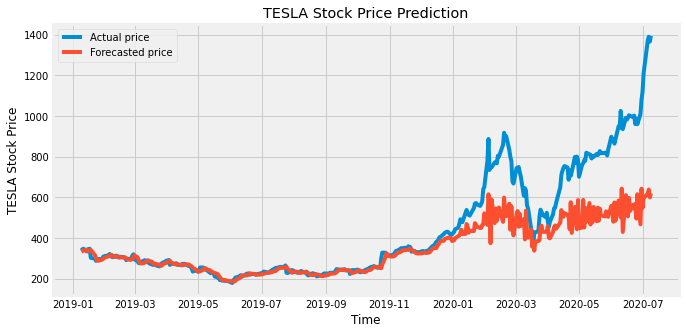

In [ ]:
# Visualising the results
actual = df.iloc[len(training_set):]['Close']
forecast = predicted_stock_price.flatten() # 把 2-d array 變成 1-d array

plt.figure(figsize=(10, 5))
plt.plot(actual.index, actual.values, label='Actual price')
plt.plot(actual.index, predicted_stock_price, label='Forecasted price')

plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.legend()
plt.show()